# 序章

## ライブラリ・コマンドの準備
バグ(Error loading preloads)発生時：Reload Windowせよ

Open the Command Palette (Ctrl + Shift + P)
Then type: Reload Window

In [1]:
# 必要ライブラリ・コマンドの導入
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
w = !apt install tree
print(w[-2])

Reading state information...


In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 初期設定

In [3]:
# 初期設定

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# warning表示off
import warnings
warnings.simplefilter('ignore')

In [4]:
# デバイスの割り当て (8章)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# 共通関数の読み込み (9章)

# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## 学習データ読み込み

In [6]:
# 学習用データの取り込み (12章)

# 学習用イメージのダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 学習用イメージの展開
w = !unzip dog_wolf.zip
print(w[-1])
 # ディレクトリ名の設定
data_dir = 'dog_wolf'

# ディレクトリ名設定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# 分類先クラス名設定
classes = ['dog', 'wolf']

# 解凍結果のツリー表示
!tree dog_wolf

2022-08-28 14:40:19 (22.8 MB/s) - ‘dog_wolf.zip.4’ saved [21811374/21811374]
(EOF or read error, treating as "[N]one" ...)
/bin/bash: tree: command not found


In [7]:
# 学習用データの準備 (8章、10章、12章)

# transformの定義
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

# datasetの定義
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# dataloaderの定義
batch_size = 5
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)


## 学習データのイメージ表示

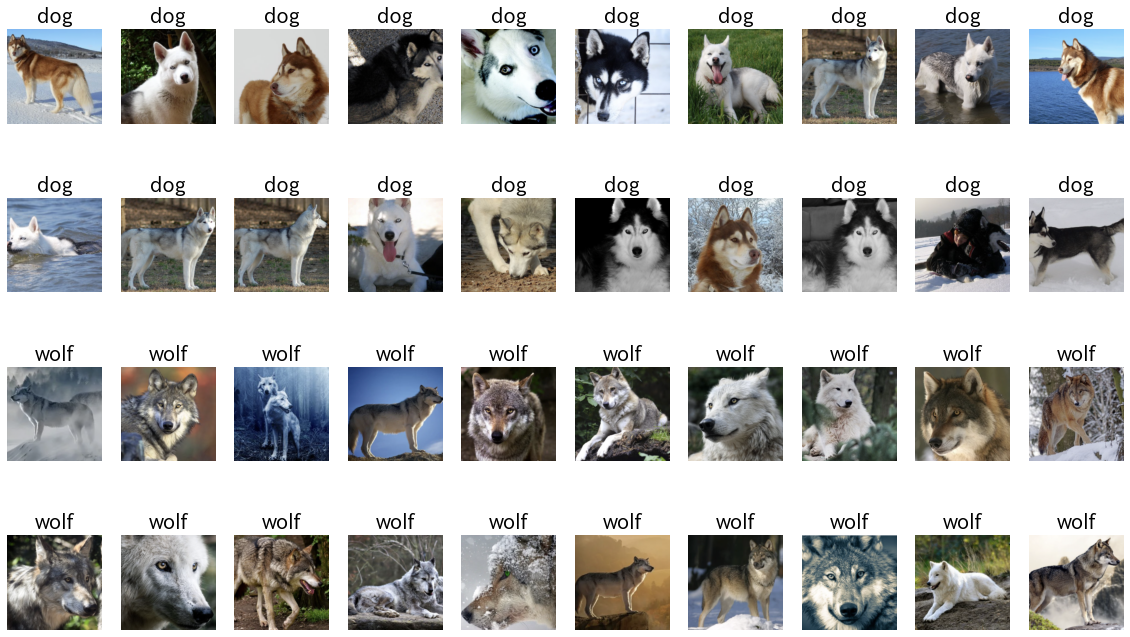

In [8]:
# 学習用データ(４0件)
show_images_labels(train_loader2, classes, None, None)

## 検証データのイメージ表示

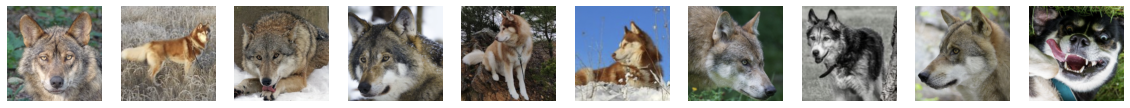

In [9]:
# 検証用データ(10件)
# 最初に正解なしでイメージのみ表示します。
# それぞれの写真がイヌかオオカミか、各自判断してみて下さい。
torch_seed()
show_images_labels(test_loader2, ['', ''], None, None)

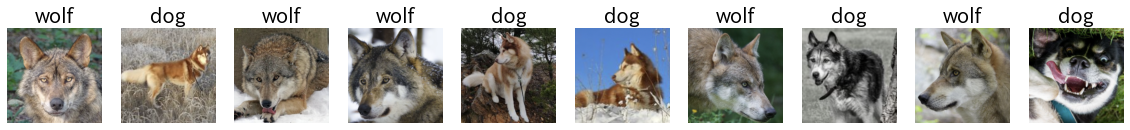

In [10]:
# 検証用データ(10件)
# こちらが正解データです。
# 10件中何件正解できたでしょうか？
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## モデル構築

In [11]:
# 事前学習済みモデルを利用したモデル構築 (11章)

# 事前学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 転移学習のためrequired_gradフラグをFalseにする
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義

# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [12]:
# 下記bug回避
# IProgress not found. Please update jupyter & ipywidgets
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [13]:
# 学習の実行 (9章)

# 繰り返し回数
num_epochs = 10

# 学習(共通関数)
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.12345 acc: 0.65000 val_loss: 0.07786, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.07584 acc: 0.85000 val_loss: 0.04893, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.03977 acc: 0.92500 val_loss: 0.05757, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.04214 acc: 0.92500 val_loss: 0.03989, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.01836 acc: 0.97500 val_loss: 0.02969, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.02143 acc: 0.97500 val_loss: 0.04183, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.03018 acc: 0.95000 val_loss: 0.03631, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.04319 acc: 0.92500 val_loss: 0.03181, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01086 acc: 1.00000 val_loss: 0.02764, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.04417 acc: 0.92500 val_loss: 0.03187, val_acc: 1.00000


## 結果確認

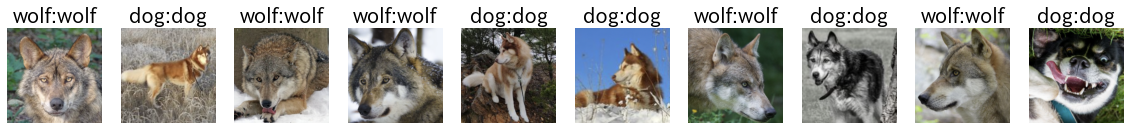

In [14]:
# 検証データを対象とした結果確認 (9章　共通関数)
torch_seed()
show_images_labels(test_loader2, classes, net, device)

## (参考)　共通関数の中身

In [15]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history


In [16]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


In [17]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True
